In [5]:
# !pip install dahuffman

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2
from collections import Counter
import os
from dahuffman import HuffmanCodec
import pickle

In [2]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

zigzag_template = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]


def matrix_to_zigzag(m):
    zigzag_iteration = [m[i, j] for i, j in zigzag_template]
    return zigzag_iteration


def zigzag_to_matrix(l):
    m = np.zeros((8, 8))
    for i in range(64):
        r, c = zigzag_template[i]
        m[r, c] = int(l[i])
    return m    




C:\Users\maria\AppData\Local\Temp\ipykernel_22916\96679357.py:69: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  def gray_encoding(img = misc.ascent(), name = "scara"):
C:\Users\maria\AppData\Local\Temp\ipykernel_22916\96679357.py:101: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


262144
180427


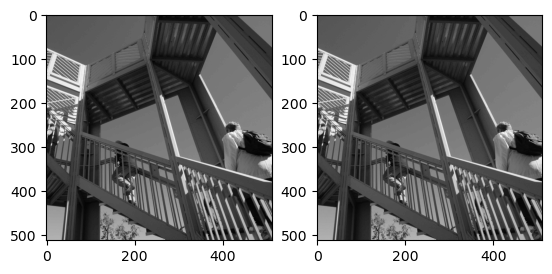

In [30]:
# sarcina 1
def jpeg_encoding(X):
    r, c = X.shape
    r8 = int(np.ceil(r/8) * 8)
    c8 = int(np.ceil(c/8) * 8)
    
    padding_r = r8 - r 
    padding_c = c8 - c
    
    X_ext = cv2.copyMakeBorder(X, 0, padding_c, 0, padding_r, cv2.BORDER_CONSTANT, value=0)

    # luam pe rand fiecare bloc de 8x8 
    # ii facem dctn + cuantizare
    # parcurgem blocul in zig zag si concatenam raspunsurile de la fiecare bloc
    # aplicam huffman pe sirul concatenat

    zigzag_concatenat = []

    for i in range(int(r8/8)):
        for j in range(int(c8/8)):
            # extragerea blocului:
            x = X_ext[8*i:8*i + 8, 8*j:8*j + 8]

            # aplicarea dctn:
            y = dctn(x)

            # cuantizare:
            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            # parcurgere zigzag:
            y_zigzag = matrix_to_zigzag(y_jpeg)
            
            # concatenare rezultat:
            zigzag_concatenat.extend(y_zigzag)

    encoded_data = list(map(int, zigzag_concatenat))
    
    # TODO: Huffman encoding

    print(len(encoded_data))
    
    huffman_codec = HuffmanCodec.from_data(encoded_data)
    encoded = huffman_codec.encode(encoded_data)

    print(len(encoded))
    
    return encoded, huffman_codec, r8, c8



def jpeg_decoding(enc, huffman_codec, r, c):
    # TODO: Huffman decoding
    encoded_data = huffman_codec.decode(enc)
    
    X_jpeg = np.zeros((r, c))
    matrix_list = []
    for i in range(int(len(encoded_data)/64)):
        y = zigzag_to_matrix(encoded_data[i*64 : i*64+64])
        x_jpeg = idctn(y)

        matrix_list.append(x_jpeg)
    count = 0
    for i in range(int(r/8)):
        for j in range(int(c/8)):
            X_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = matrix_list[count]
            count += 1
    
    return X_jpeg 

def gray_encoding(img = misc.ascent(), name = "scara"):
    enc, huffman_codec, r, c = jpeg_encoding(img)

    # salvam in fisier binar
    dict_img = {
        "r" : r,
        "c" : c,
        "huffman_codec" : huffman_codec, 
        "data" : enc
    }
    with open(f"{name}.bin", "wb") as fisier:
        pickle.dump(dict_img, fisier)


def gray_decoding(name): 
    with open(f"{name}.bin", "rb") as fisier:
        date_incarcate = pickle.load(fisier)

    r_c = date_incarcate["r"]
    c_c = date_incarcate["c"]
    huffman_codec_c = date_incarcate["huffman_codec"]
    data_c = date_incarcate["data"]
    dec = jpeg_decoding(data_c, huffman_codec_c, r_c, c_c)

    plt.subplot(121).imshow(X, cmap=plt.cm.gray)
    plt.subplot(122).imshow(dec, cmap=plt.cm.gray)
    plt.show()


X = misc.ascent()
name = "scara"
gray_encoding(X, name)
gray_decoding(name)


C:\Users\maria\AppData\Local\Temp\ipykernel_22916\3892792783.py:123: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


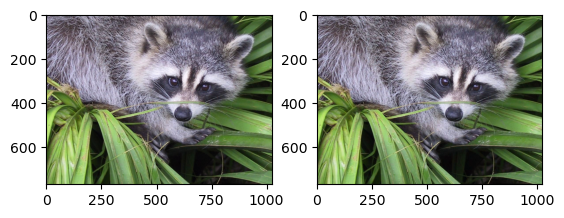

In [15]:
# codare si decodare pentru imagini color (sarcina 2)

def jpeg_color_encoding(X, f=1):

    # conversia de la RGB la YCrCb
    X = cv2.cvtColor(X, cv2.COLOR_BGR2YCR_CB)
    
    r, c, _ = X.shape
    r8 = int(np.ceil(r/8) * 8)
    c8 = int(np.ceil(c/8) * 8)
    
    padding_r = r8 - r 
    padding_c = c8 - c
    
    X_ext = cv2.copyMakeBorder(X, 0, padding_c, 0, padding_r, cv2.BORDER_CONSTANT, value=[0,0,0])

    zigzag_concatenat = [] 

    for i in range(int(r8/8)):
        for j in range(int(c8/8)):
            # extragerea blocului:
            x = X_ext[8*i:8*i + 8, 8*j:8*j + 8]

            x_y, x_cr, x_cb = cv2.split(x)

            # aplicarea dctn:
            y_y = dctn(x_y)
            y_cr = dctn(x_cr)
            y_cb = dctn(x_cb)

            # cuantizare:
            Q_jpeg2 = [[f * elem for elem in line] for line in Q_jpeg]
            
            y_y_jpeg = Q_jpeg2*np.round(y_y/Q_jpeg)
            y_cr_jpeg = Q_jpeg2*np.round(y_cr/Q_jpeg)
            y_cb_jpeg = Q_jpeg2*np.round(y_cb/Q_jpeg)

            # parcurgere zigzag:
            y_y_zigzag = matrix_to_zigzag(y_y_jpeg)
            y_cr_zigzag = matrix_to_zigzag(y_cr_jpeg)
            y_cb_zigzag = matrix_to_zigzag(y_cb_jpeg)
            
            # concatenare rezultat:
            zigzag_concatenat.extend(y_y_zigzag)
            zigzag_concatenat.extend(y_cr_zigzag)
            zigzag_concatenat.extend(y_cb_zigzag)

    data = list(map(int, zigzag_concatenat))

    # TODO: Huffman coding
    
    huffman_codec = HuffmanCodec.from_data(data)
    encoded = huffman_codec.encode(data)

    return encoded, huffman_codec, r8, c8



def jpeg_color_decoding(enc, huffman_codec, r, c):
    # TODO: Huffman decoding

    encoded_data = huffman_codec.decode(enc)
    
    
    X_jpeg = np.zeros((r, c, 3))
    matrix_list = []
    for i in range(int(len(encoded_data)/192)):
        block = encoded_data[i*192 : i*192+192]
        
        y_y = zigzag_to_matrix(block[:64])
        y_cr = zigzag_to_matrix(block[64:128])
        y_cb = zigzag_to_matrix(block[128:])
        
        x_y_jpeg = np.maximum(0, idctn(y_y))
        x_cr_jpeg = np.maximum(0, idctn(y_cr))
        x_cb_jpeg = np.maximum(0, idctn(y_cb))

        x_y_jpeg = x_y_jpeg.astype(int)
        x_cr_jpeg = x_cr_jpeg.astype(int)
        x_cb_jpeg = x_cb_jpeg.astype(int)
        
        x_jpeg = cv2.merge((x_y_jpeg, x_cr_jpeg, x_cb_jpeg))
        
        matrix_list.append(x_jpeg)
    count = 0
    for i in range(int(r/8)):
        for j in range(int(c/8)):
            X_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = matrix_list[count]
            count += 1
    X_jpeg = np.clip(X_jpeg, 0, 255).astype(np.uint8)
    X_jpeg = cv2.cvtColor(X_jpeg, cv2.COLOR_YCrCb2BGR)
    return X_jpeg

def color_encoding(img = misc.face(), name = "raton"):
    enc, huffman_codec, r, c = jpeg_color_encoding(img)

    # salvam in fisier binar
    dict_img = {
        "r" : r,
        "c" : c,
        "huffman_codec" : huffman_codec, 
        "data" : enc
    }
    with open(f"{name}.bin", "wb") as fisier:
        pickle.dump(dict_img, fisier)


def color_decoding(name): 
    with open(f"{name}.bin", "rb") as fisier:
        date_incarcate = pickle.load(fisier)

    r_c = date_incarcate["r"]
    c_c = date_incarcate["c"]
    huffman_codec_c = date_incarcate["huffman_codec"]
    data_c = date_incarcate["data"]
    dec = jpeg_color_decoding(data_c, huffman_codec_c, r_c, c_c)

    plt.subplot(121).imshow(X)
    plt.subplot(122).imshow(dec)
    plt.show()


X = misc.face()
name = "raton2"
color_encoding(X, name)
color_decoding(name)



C:\Users\maria\AppData\Local\Temp\ipykernel_22916\2428130263.py:35: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


alegeti pragul mse 43


incercam factor=1 si obtinem mse:  5.994578043619792
incercam factor=1.07 si obtinem mse:  254.4327189127604
incercam factor=1.0350000000000001 si obtinem mse:  196.04239400227866
incercam factor=1.0175 si obtinem mse:  41.093448638916016


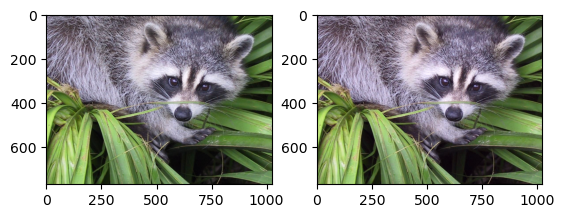

In [16]:
# sarcina 3
def compute_mse(X_origin, X_jpeg):
    # aducem imaginile la acelasi shape 
    # (in unele cazuri shape ul lui X_jpeg poate fi mai mare din cauza padding ului)
    X_origin_ext = np.zeros_like(X_jpeg)
    X_origin_ext = X_origin_ext + X_origin
    return np.sum((X_origin_ext - X_jpeg) ** 2) / (X_jpeg.shape[0] * X_jpeg.shape[1])

def find_mse(prag, X, verbose=False):
    ff = 1
    add = 0.07
    
    while(True):
        encoded_data,huffman_codec, r, c = jpeg_color_encoding(X, f=ff)
        decoded_data = jpeg_color_decoding(encoded_data, huffman_codec, r, c)
        mse = compute_mse(X, decoded_data)
        dif = mse - prag
        
        if verbose:
            print(f"incercam factor={ff} si obtinem mse: ", mse)
        
        if abs(dif) > 3:
            if dif > 0:
                ff = ff - add
                add /= 2
            else:
                ff = ff + add
                add /= 2
        else:
            break
    
    return decoded_data, mse, ff


X = misc.face()
prag = int(input("alegeti pragul mse"))

decoded_data, mse_opt, f = find_mse(prag, X, verbose=True)

plt.subplot(121).imshow(X)
plt.subplot(122).imshow(decoded_data)
plt.show()


In [38]:
# sarcina 4
def extract_frames(video_path, n=10):
    
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    frames = []
    huffman_codes = []
    
    frame_count = 0
    
    for _ in range(n): # pentru primele n frameuri
    # while True: # pentru tot videoul dar dureaza aproximativ 12 minute
        ret, frame = cap.read()
        if not ret:
            print("End of video.")
            break
            
        encoded_frame, huffman_codec, r, c = jpeg_color_encoding(frame)
        frames.append(encoded_frame)
        huffman_codes.append(huffman_codec)
        
        frame_count += 1

    cap.release()
    
    return frames, huffman_codes, r, c, frame_count


def video_encoding(video_path = "highway.mp4", number_of_frames = 10):
    print("encoding frames...")
    
    frames, huffman_codes, r, c, frame_count = extract_frames(video_path, number_of_frames)
    dict_video = {
        "r" : r,
        "c" : c,
        "frame_count" : frame_count,
        "huffman_codes" : huffman_codes, 
        "data" : frames
    }
    name = f"nr_{frame_count}_frames"
    with open(f"{name}.bin", "wb") as fisier:
        pickle.dump(dict_video, fisier)
    
    print("finish encoding.")
    return name

    
def video_decoding(name):
    print("decoding frames...")
    with open(f"{name}.bin", "rb") as fisier:
        date_incarcate = pickle.load(fisier)

    r_c = date_incarcate["r"]
    c_c = date_incarcate["c"]
    frame_count_c = date_incarcate["frame_count"]
    huffman_codes_c = date_incarcate["huffman_codes"]
    data_c = date_incarcate["data"]

    decoded_frames = []
    for i in range(frame_count_c):
        decoded_frame = jpeg_color_decoding(data_c[i], huffman_codes_c[i], r_c, c_c)
        decoded_frames.append(decoded_frame)

    print("finish decoding.")
    return decoded_frames


video_path = "highway.mp4"

name = video_encoding(video_path, 10)
decoded_frames = video_decoding(name)


encoding frames...
finish encoding.
decoding frames...
finish decoding.
